In [1]:
# Importing all of the dependencies to run the code

In [2]:
!pip install --user keras

In [4]:
!pip install --user soundfile

In [1]:
import numpy as np
import pandas as pd
import tensorflow
import keras

from IPython.display import Audio
from keras.layers import Dense, LSTM, LeakyReLU
from keras.models import Sequential, load_model
from scipy.io.wavfile import read, write
import soundfile

Using TensorFlow backend.


In [2]:
# Adapting the files so that they are 16-bit instead of 24-bit to be compatible with soundfile

In [3]:
for i in range(10):
    data, samplerate = soundfile.read('0' + str(i) +'.wav')
    soundfile.write('new_' + str(i) + '.wav', data, samplerate, subtype='PCM_16')

In [63]:
# Ended up not needing this portion of the data but to go even further there's more data available
#for i in range(10,17):
#    data, samplerate = soundfile.read(str(i) +'.wav')
#    soundfile.write('new_' + str(i) + '.wav', data, samplerate, subtype='PCM_16')

In [64]:
# Reading all of the wavedata into an array, appending it to a list

In [4]:
res = []
for i in range(10):
    rate, music1 = read('new_'+str(i)+'.wav')
    res.append(music1)

In [5]:
# Concatenating the list so the data is all in one array

In [6]:
res = (np.concatenate(res))

In [72]:
music1 = res[7000000:8000000] 
music2 = res[8000001:9000000]

In [73]:
# taking parts of the songs and converting them into a dataframe
music1 = pd.DataFrame(music1[0:500000, :])
music2 = pd.DataFrame(music2[0:500000, :])

In [74]:
# Creating the training data for the LSTM
def create_train_dataset(df, shift):
    dataX1, dataX2 , dataY1 , dataY2 = [],[],[],[]
    for i in range(len(df)-shift-1):
        dataX1.append(df.iloc[i : i + shift, 0].values)
        dataX2.append(df.iloc[i : i + shift, 1].values)
        dataY1.append(df.iloc[i + shift, 0])
        dataY2.append(df.iloc[i + shift, 1])
    return np.array(dataX1), np.array(dataX2), np.array(dataY1), np.array(dataY2)

In [75]:
X1 , X2, y1 , y2 = create_train_dataset(pd.concat([music1.iloc[0 : 200000],music2.iloc[0 : 200000]], axis=0), 3)

In [76]:
print(X1.shape)
print(X2.shape)
print(y1.shape)
print(y2.shape)

(399996, 3)
(399996, 3)
(399996,)
(399996,)


In [77]:
# Creating the testing data
def create_test_data(df, shift):
    dataX1, dataX2 = [], []
    for i in range(len(df)-shift-1):
        dataX1.append(df.iloc[i : i + shift, 0].values)
        dataX2.append(df.iloc[i : i + shift, 1].values)
        
    return np.array(dataX1), np.array(dataX2)

In [78]:
test1, test2 = create_test_data(pd.concat([music1.iloc[200001 : 500000, :],music2.iloc[200001 : 500000, :]], axis=0), 3)

In [79]:
X1 = X1.reshape((-1, 1, 3))
X2 = X2.reshape((-1, 1, 3))

In [80]:
# Credit to animesharm97's repo on GitHub for this contruction of the RNN/LSTM, which was adapted to fit this project

In [81]:
# LSTM Model for channel 1 of the music data
rnn1 = Sequential()
rnn1.add(LSTM(units=100, activation='linear', input_shape=(None, 3)))
rnn1.add(LeakyReLU())
rnn1.add(Dense(units=50, activation='linear'))
rnn1.add(LeakyReLU())
rnn1.add(Dense(units=25, activation='linear'))
rnn1.add(LeakyReLU())
rnn1.add(Dense(units=12, activation='linear'))
rnn1.add(LeakyReLU())
rnn1.add(Dense(units=1, activation='linear'))
rnn1.add(LeakyReLU())

rnn1.compile(optimizer='adam', loss='mean_squared_error')
rnn1.fit(X1, y1, epochs=5, batch_size=100)

Epoch 1/5
399996/399996 [==============================] - 45s 113us/step - loss: 10772.6838
Epoch 2/5
399996/399996 [==============================] - 44s 110us/step - loss: 262.4606
Epoch 3/5
399996/399996 [==============================] - 44s 110us/step - loss: 176.8506
Epoch 4/5
399996/399996 [==============================] - 44s 111us/step - loss: 101.0243
Epoch 5/5
399996/399996 [==============================] - 45s 111us/step - loss: 70.5446


In [82]:
# LSTM Model for channel 2 of the music data
rnn2 = Sequential()
rnn2.add(LSTM(units=100, activation='linear', input_shape=(None, 3)))
rnn2.add(LeakyReLU())
rnn2.add(Dense(units=50, activation='linear'))
rnn2.add(LeakyReLU())
rnn2.add(Dense(units=25, activation='linear'))
rnn2.add(LeakyReLU())
rnn2.add(Dense(units=12, activation='linear'))
rnn2.add(LeakyReLU())
rnn2.add(Dense(units=1, activation='linear'))
rnn2.add(LeakyReLU())

rnn2.compile(optimizer='adam', loss='mean_squared_error')
rnn2.fit(X2, y2, epochs=5, batch_size=100)

Epoch 1/5
399996/399996 [==============================] - 45s 112us/step - loss: 17992.6513
Epoch 2/5
399996/399996 [==============================] - 44s 110us/step - loss: 590.2175
Epoch 3/5
399996/399996 [==============================] - 44s 109us/step - loss: 387.5127
Epoch 4/5
399996/399996 [==============================] - 44s 109us/step - loss: 250.8452
Epoch 5/5
399996/399996 [==============================] - 44s 109us/step - loss: 257.6063


In [83]:
# saving LSTM models
rnn1.model.save('rnn1.h5')
rnn2.model.save('rnn2.h5')

In [84]:
# loading the saved models
rnn1 = load_model('rnn1.h5')
rnn2 = load_model('rnn2.h5')

In [85]:
# making predictions for channel 1 and channel 2
pred_rnn1 = rnn1.predict((test1.reshape(-1, 1, 3)))
pred_rnn2 = rnn2.predict(test2.reshape(-1, 1, 3))

In [86]:
# saving the LSTM predicitons in wav format
write('pred_rnn7.wav', rate, pd.concat([pd.DataFrame(pred_rnn1.astype('int16')), pd.DataFrame(pred_rnn2.astype('int16'))], axis=1).values)

In [90]:
# saving the original music in wav format
write('original3.wav',rate, pd.concat([music1.iloc[400001 : 1000000, :], music2.iloc[400001 : 1000000, :]], axis=0).values)

In [91]:
Audio("pred_rnn7.wav")

In [92]:
Audio("original3.wav")

In [25]:
# Displaying the waveplots of the data

In [26]:
import matplotlib.pyplot as plt

In [27]:
%matplotlib inline

In [28]:
# Plot of the generated wave

Waveplot of Predicted Values, 2


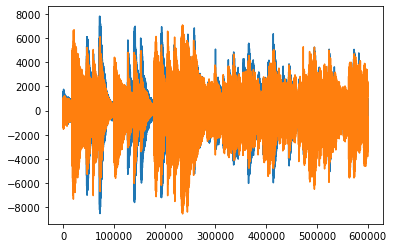

In [29]:
plt.plot(pd.concat([pd.DataFrame(pred_rnn1.astype('int16')), pd.DataFrame(pred_rnn2.astype('int16'))], axis=1).values)
print("Waveplot of Predicted Values, 2")

In [30]:
# Plot of the training data wave

Waveplot of Original Values, 2


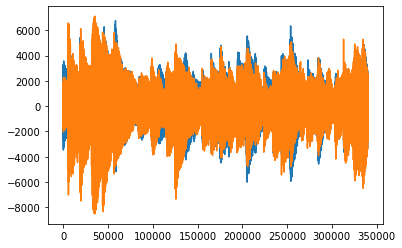

In [31]:
plt.plot(pd.concat([music1.iloc[400001 : 1000000, :], music2.iloc[400001 : 1000000, :]], axis=0).values)
print('Waveplot of Original Values, 2')